In [2]:
# ربط Google Drive مع Google Colab للوصول إلى الملفات
from google.colab import drive

# تثبيت Google Drive في هذا المسار للوصول إلى الملفات عبره
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

# مكتبة NLTK لإزالة التوقفات (قد تحتاج تنزيلها لاحقًا)
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# تقسيم البيانات والبحث الشبكي
from sklearn.model_selection import train_test_split, GridSearchCV

# تحويل النصوص إلى خصائص رقمية
from sklearn.feature_extraction.text import TfidfVectorizer

# إنشاء pipeline لتبسيط خطوات التدريب
from sklearn.pipeline import make_pipeline

# نماذج تصنيف مختلفة
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# تقييم النموذج
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# تجاهل التحذيرات
import warnings
warnings.filterwarnings("ignore")
import openpyxl
import joblib

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:

from google.colab import files
uploaded = files.upload()

import pandas as pd

df = pd.read_excel("Book 5.xlsx")

Saving Book 5.xlsx to Book 5.xlsx


In [5]:
df.columns = df.columns.str.strip()
df['label'] = 0            # نعين كل القيم بـ 0 أولاً
df.loc[0:1046, 'label'] = 1  # نعين القيم من السطر 0 إلى 1046 بـ 1 فقط


In [6]:
print(df['label'].value_counts())
print(df.iloc[1045:])


label
1    1047
0     635
Name: count, dtype: int64
                                               sentence           token  label
1045  تَسْتَخْدِمُ الطُّيُورُمَنَاقِيرَهَا لِجَمْعِ ...   مَنَاقِيرَهَا      1
1046  تَزَيَّنَ المَسْجِدُ بِالمَحَارِيبِ المُزَخْرَ...  بِالمَحَارِيبِ      1
1047  مُبَرْمِجُونَ يُطَوِّرُونَ التَّطْبِيقَاتِ الْ...   مُبَرْمِجُونَ      0
1048  مُهَنْدِسُونَ يُشْرِفُونَ عَلَى الْمَشَارِيعِ ...   مُهَنْدِسُونَ      0
1049  حِرَفِيُّونَ يَصْنَعُونَ الْمُنْتَجَاتِ الْيَد...    حِرَفِيُّونَ      0
...                                                 ...             ...    ...
1677  تعالتْ أصواتُ المغنياتِ في مهرجانِ الطربِ العر...             NaN      0
1678  التفتَ العشاقُ لضحكاتِ العاشقاتِ وهي تهمسُ بال...             NaN      0
1679  خَطَّتِ الحروفُ على صفحاتِ الدواوينِ بيدِ الشا...             NaN      0
1680  خَطَّتِ الحروفُ على صفحاتِ الدواوينِ بيدِ الشا...             NaN      0
1681  رَوَتِ الجداتُ قصصًا تنسجُ الحكمةَ في أعماقِ ا...             NaN      0


In [7]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd

# تحميل قائمة التوقّف من NLTK مرّة واحدة
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('arabic'))

# ───────── القائمة المخصَّصة التي زوّدتني بها ─────────
custom_stopwords = set([
    'إذ','إذا','إذما','إذن','آه','آها','إلى','إلي','إليك','إليكم','إليكما','إليكن',
    'أم','أما','إما','أن','إن','إنا','أنا','أنتم','أنتما','أنتن','أنى','أو','أولئك',
    'أولاء','إي','إياك','إياكم','إياكما','إياكن','إياه','إياها','إياهم','إياهما',
    'إياهن','إياي','إيانا','إذ','إذًا','بخٍ','بس','بعد','بعض','بك','بكم','بكما',
    'بكن','به','بها','بهم','بهما','بهن','بي','بنا','بين','بيد','تلك','تلكم','تلكما',
    'ثم','ثمة','حاشا','حبذا','حتى','حيث','حيثما','حين','خلا','دون','ذا','ذات','ذاك',
    'ذو','ذي','ذين','ذلك','ذلكم','ذلكما','ذه','هذه','هكذا','هل','هلا','هم','هما',
    'هن','هو','هي','هيا','هيت','هيهات','وا','وإذا','وإن','والذي','والتي','ولا','ولكن',
    'ولو','وما','ومن','وهو','يا','أجل','أجمع','أخ','أخا','أخو','أف','أقل','أمام','أمس',
    'أنى','أول','أين','أي','أيا','بخ','بس','ثم','تحت','جلل','خلف','خلال','دون','ذات',
    'رغم','سوف','سوى','شبه','صه','ضد','ضمن','طرا','عدا','عدد','عسى','عل','على',
    'عليك','عند','غير','فإذا','فإن','فقط','قبل','قد','كأن','كأنما','كأي','كأين','كاد',
    'كان','كأن','كذا','كذلك','كل','كلا','كلتا','كلم','كم','كي','كيف','كيفما','لا',
    'لاسيما','لات','لدى','لست','لعل','لكن','لكي','لم','لن','لو','لولا','لوما','ليت',
    'ليس','ما','ماذا','مازال','متى','مثل','مثلا','مد','مذ','مع','معاذ','مما','من',
    'منذ','مه','مهما','نحن','نحو','نعم','ها','هاتان','هاته','هاتي','هاتهما','هاتيكم',
    'هاتهما','هاته','هاك','هاكم','هانا','هؤلاء','هاهنا','هيهات','و','واحد','وإن',
    'وراء','وسط','وما','وهي','وهو','أثناء','يا'
])
# ─────────────────────────────────────────

# دمج القائمتين
all_stopwords = nltk_stopwords.union(custom_stopwords)

# ---------- دوال التنظيف ----------
def remove_diacritics(text):
    diacritics_pattern = re.compile(r""" ّ|َ|ً|ُ|ٌ|ِ|ٍ|ْ|ـ """, re.VERBOSE)
    return re.sub(diacritics_pattern, '', text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_stopwords(text):
    return ' '.join([w for w in text.split() if w not in all_stopwords])

def remove_definite_article(text):
    exceptions = {"الله", "الذي", "التي", "الذين", "اللهم", "الآن"}
    processed = [(w[2:] if w.startswith("ال") and w not in exceptions else w)
                 for w in text.split()]
    return ' '.join(processed)

def clean_text(text):
    text = remove_diacritics(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    return text

# تطبيق دالة التنظيف على عمود 'sentence' وحفظه في عمود جديد
df['clean_sentence'] = df['sentence'].astype(str).apply(clean_text)

# عرض أول خمسة أسطر للمقارنة
print(df[['sentence', 'clean_sentence']].head())



                                         sentence  \
0                 ساعدنا أرامل الحي في جمع الحطب.   
1  جلس الزوار على الأرائك المريحة أثناء الانتظار.   
2           اجتمع الأقارب في مناسبة عائلية كبيرة.   
3          ارتدت المرأة الأساور الذهبية في الحفل.   
4                     سافرنا إلى الأماكن النائية.   

                        clean_sentence  
0          ساعدنا أرامل الحي جمع الحطب  
1  جلس الزوار الأرائك المريحة الانتظار  
2    اجتمع الأقارب مناسبة عائلية كبيرة  
3   ارتدت المرأة الأساور الذهبية الحفل  
4               سافرنا الأماكن النائية  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from sklearn.model_selection import train_test_split

# نفصل الميزات (X) عن التصنيفات (y)
X = df["sentence"]          # أو أي اسم عمود عندك
y = df["label"]

# تقسيم البيانات: 80٪ تدريب، 20٪ اختبار
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,         # غيّرها لو حاب نسبة مختلفة
    random_state=42,        # لضمان نفس العينة كل مرة (قابل لإعادة الإنتاج)
    stratify=y              # يحافظ على توازن الفئات في Train/Test
)

print(f"حجم بيانات التدريب: {X_train.shape[0]}")
print(f"حجم بيانات الاختبار: {X_test.shape[0]}")


حجم بيانات التدريب: 1345
حجم بيانات الاختبار: 337


In [14]:
# ─────────────────────────────
# 1) المكتبات
# ─────────────────────────────
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# ─────────────────────────────
# 2) تقسيم البيانات
# ─────────────────────────────
X = df["clean_sentence"].astype(str)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# ─────────────────────────────
# 3) محوِّل TF-IDF (Unigram Word)
# ─────────────────────────────
tfidf_vect = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 1),   # Unigram فقط
    max_features=5000,    # لم نضع حدًّا
    sublinear_tf=False    # الإعداد الافتراضي
)

X_train_vec = tfidf_vect.fit_transform(X_train)
X_test_vec  = tfidf_vect.transform(X_test)

# ─────────────────────────────
# 4) نموذج SVM خطّي
# ─────────────────────────────
svm79 = SVC(
    kernel="linear",
    C=1.0,
    probability=False,     # لم نطلب احتمالات
    random_state=42
)
svm79.fit(X_train_vec, y_train)

# ─────────────────────────────
# 5) التنبؤ والتقييم
# ─────────────────────────────
y_pred = svm79.predict(X_test_vec)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8131

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.57      0.70       127
           1       0.79      0.96      0.86       210

    accuracy                           0.81       337
   macro avg       0.84      0.77      0.78       337
weighted avg       0.83      0.81      0.80       337



In [10]:
# =========================================
#  كود اختبار بسيط لنموذج svm79 و tfidf_vect
#  (يفترض أن svm79 و tfidf_vect محمَّلان في الذاكرة)
# =========================================

import re

# 1) جُمَل تريد اختبارها
test_sentences = [
    "جلس الأولاد على المقاعد.",
    "قرأت كتبًا علمية مفيدة.",
    "اشترى الأطفالُ ألعابًا جميلة."
]

# 2) دالة تنظيف مختصرة لتطابق ما استُخدم في التدريب
def quick_clean(text):
    text = re.sub(r"[ًٌٍَُِّْـ]", "", text)   # حذف التشكيل
    text = re.sub(r"[^\w\s]", "", text)       # حذف الترقيم
    return text.strip()

cleaned = [quick_clean(s) for s in test_sentences]

# 3) تحويل الجمل إلى تمثيل TF-IDF
X_test_custom = tfidf_vect.transform(cleaned)

# 4) التنبؤ باستخدام النموذج المدرب
preds = svm79.predict(X_test_custom)

# 5) عرض النتائج
for sent, lbl in zip(test_sentences, preds):
    verdict = "يحتوي جمع تكسير" if lbl == 1 else "لا يحتوي جمع تكسير"
    print(f"{sent}  →  {verdict}")


جلس الأولاد على المقاعد.  →  يحتوي جمع تكسير
قرأت كتبًا علمية مفيدة.  →  يحتوي جمع تكسير
اشترى الأطفالُ ألعابًا جميلة.  →  يحتوي جمع تكسير


In [11]:
# ───────── 5) ‎K‑Fold Validation‏ (5 طيّات)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion

# ‏إنشاء متّحد الميزات (Word + Char) إنْ لم يكن موجوداً
features = FeatureUnion([
    ("word", TfidfVectorizer(
        analyzer="word",
        ngram_range=(1, 2),
        max_features=3000,
        sublinear_tf=True)),
    ("char", TfidfVectorizer(
        analyzer="char_wb",
        ngram_range=(3, 5),
        max_features=5000,
        sublinear_tf=True))
])

# ‏بايبلاين كامل = (استخراج الميزات → SVM)
pipe = Pipeline([
    ("features", features),
    ("clf", SVC(
        C=1.0,
        kernel="linear",          # خطّي (يفيد غالباً مع النصوص)
        class_weight="balanced",
        random_state=42))
])

# ‏5‑Fold (Stratified) مع خلط مسبق
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ‏احسب دقة كل طيّة
cv_scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")

print("دقة كل طيّة:", np.round(cv_scores, 4))
print("المتوسط ± الانحراف:", f"{cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


دقة كل طيّة: [0.9228 0.8872 0.9018 0.9286 0.9137]
المتوسط ± الانحراف: 0.9108 ± 0.0149


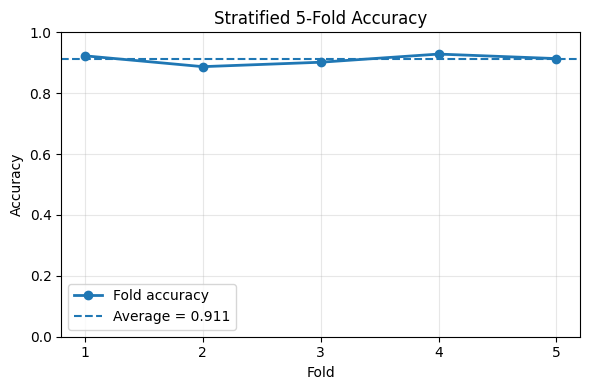

In [12]:
# ـــــــ  رسم دقّات K‑Fold  ـــــــ
import numpy as np
import matplotlib.pyplot as plt

folds = np.arange(1, len(cv_scores) + 1)   # 1, 2, …, k

plt.figure(figsize=(6, 4))
plt.plot(folds, cv_scores, marker='o', linewidth=2, label='Fold accuracy')
plt.axhline(cv_scores.mean(), linestyle='--',
            label=f'Average = {cv_scores.mean():.3f}')

plt.title('Stratified 5‑Fold Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(folds)
plt.ylim(0, 1)          # لأن الدقّة بين 0 و 1
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:

import joblib

joblib.dump(svm79, "finalmodel.pkl")              # النموذج


['finalmodel.pkl']

In [22]:
import joblib

joblib.dump(tfidf_vect, "finalmodelvectorizer.pkl")


['finalmodelvectorizer.pkl']

In [23]:
from google.colab import files

# تنزيل النموذج
files.download("finalmodel.pkl")
files.download("finalmodelvectorizer.pkl")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
files.download("finalmodelvectorizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>